In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-09-30 17:01:27.598392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 17:01:28.156770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
dataset = LayoutDataset(batch_size, train_sample_fraction=1.0, subset='xla', build_tfrecords=False)

2023-09-30 17:01:28.817385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 17:01:28.833544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 17:01:28.833733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(batch_size, learning_rate=1e-4, mask_max_len=500)

In [4]:
mlp.train(dataset.train_data, dataset.valid_data)

2023-09-30 17:01:32.001841: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1447936000 exceeds 10% of free system memory.
2023-09-30 17:01:33.028143: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1447936000 exceeds 10% of free system memory.
2023-09-30 17:01:35.747688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-30 17:01:35.760492: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb0793fc9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-30 17:01:35.760506: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-30 17:01:35.763573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to

iteration 100 training loss 16.030579 lr 0.00010
iteration 200 training loss 10.987841 lr 0.00010
iteration 300 training loss 5.8617992 lr 0.00010
iteration 400 training loss 3.27386 lr 0.00010
iteration 500 training loss 1.9393878 lr 0.00010
iteration 600 training loss 1.2065302 lr 0.00010
iteration 700 training loss 4.3445835 lr 0.00010
iteration 800 training loss 0.89260083 lr 0.00010
iteration 900 training loss 1.8518554 lr 0.00010
iteration 1000 training loss 1.614433 lr 0.00010
epoch 0, it 1000 validation loss 0.001
iteration 1100 training loss 1.4543141 lr 0.00009
iteration 1200 training loss 5.208366 lr 0.00009
iteration 1300 training loss 2.8257942 lr 0.00009
iteration 1400 training loss 25.612352 lr 0.00009
iteration 1500 training loss 11.564039 lr 0.00009
iteration 1600 training loss 5.3922243 lr 0.00009
iteration 1700 training loss 4.797941 lr 0.00009
iteration 1800 training loss 3.0176523 lr 0.00009
iteration 1900 training loss 3.4365034 lr 0.00009
iteration 2000 training 

KeyboardInterrupt: 

In [ ]:
mlp.normalization_layer_config_nodes.mean.numpy().flatten()

In [ ]:
plt.hist(mlp.dense_layer_3.kernel.numpy().flatten(), bins=50);

In [ ]:
for tile_ids, config_indexes, config_descriptors, valid_mask, graph_descriptor, normalized_runtimes in dataset.train_data:
    break

In [ ]:
np.unique(tile_ids.numpy())

In [ ]:
config_descriptors.numpy()[5, 0, :]

In [ ]:
config_descriptors

In [ ]:
import tensorflow as tf

In [ ]:
x = mlp.normalization_layer_config_nodes(config_descriptors)
x = mlp.dense_layer_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)

float_mask = tf.cast(valid_mask, tf.float32)  # (batch_size, n_config_nodes_upper_limit)
float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask
x = tf.reduce_mean(x, axis=1)

normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, normal_graph_descriptor], axis=-1)
x = mlp.dense_layer_2(x)
x = mlp.relu_layer(x)
x = mlp.dense_layer_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
order = np.random.permutation(np.arange(10))
new_order = order.copy()
new_order[0] = order[1]
new_order[1] = order[0]
kendalltau(order, new_order)

## Evaluate validation set

In [30]:
val_df = mlp.predict_over_dataset(dataset.train_data, return_labels=True)

In [31]:
val_df[['prediction', 'target']].describe()

,prediction,target
count,976225.000000,976225.000000
mean,19.446484,19.207014
std,4.508003,1.802261
min,11.732078,15.367673
25%,17.978468,17.955568
50%,18.588140,19.024023
75%,20.102045,20.651176
max,72.039673,27.401468


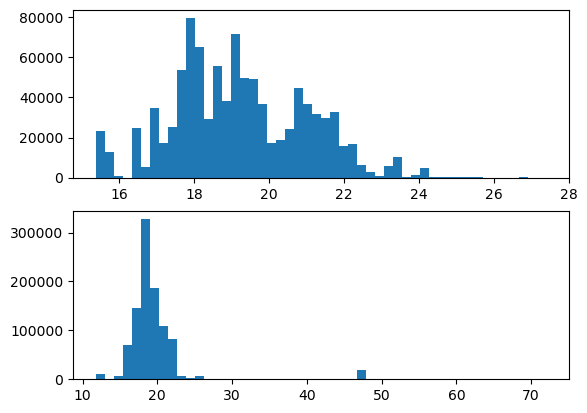

In [32]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [8]:
val_df.ID.unique()

array([b'layout:xla:random:resnet_v1_50_official_batch_128_bf16',
       b'layout:xla:random:inception_v3_batch_128_train',
       b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size',
       b'layout:xla:random:bert_pretraining.4x4.fp16',
       b'layout:xla:random:unet_3d.4x4.bf16',
       b'layout:xla:default:mlperf_bert_batch_24_2x2',
       b'layout:xla:default:unet_3d.4x4.bf16',
       b'layout:xla:random:resnet50.4x4.fp16',
       b'layout:xla:random:mlperf_bert_batch_24_2x2',
       b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',
       b'layout:xla:default:inception_v3_batch_128_train',
       b'layout:xla:default:resnet50.4x4.fp16',
       b'layout:xla:random:tf2_bert_pretrain_dynamic_batch_size',
       b'layout:xla:default:bert_pretraining.4x4.fp16'], dtype=object)

Text(0.5, 1.0, "b'layout:xla:random:resnet50_3d.2x2.bf16'")

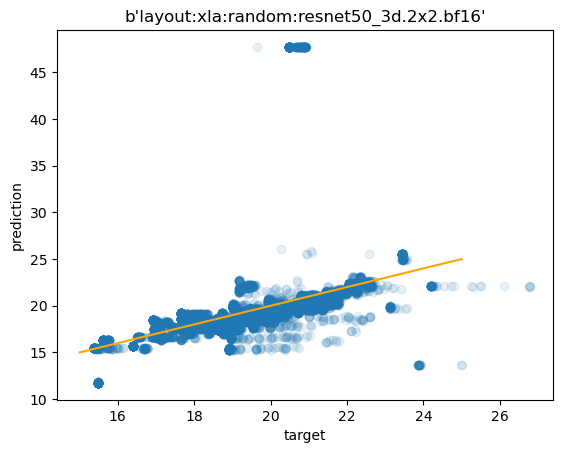

In [56]:
x_lin = np.linspace(15, 25, 100)
plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(10_000)
graph_id = np.random.choice(val_df['ID'].unique())
#random_sample = val_df[val_df['ID'] == graph_id]

plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-10.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [ ]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [ ]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

In [ ]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

In [ ]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('layout_test_prediction.csv')

In [ ]:
plt.hist(np.abs(mlp.dense_layer_1.kernel.numpy().flatten()), bins=50)